In [1]:
import cv2
import json
from src.utils.func import (crop_center, read_image_as_numpyimage, get_corners, compute_adaptive_hsv_bounds, convert_hough_segments_to_lines)
from src.utils.const import ref_snooker_playfield
from src.utils.playfield_finder import PlayfieldFinder
from src.utils.points import Point
from src.utils.lines import Line
import numpy as np
from src.utils.plotting import display_img, plot_on_image
import src.config
from src.utils.metrics import iou, _reorder_pts
from src.utils.intersections import compute_intersections
from src.utils.annotations import transform_annotation
from pathlib import Path
import pandas as pd
from src.utils.annotations import PolygonAnnotation
import matplotlib.pyplot as plt

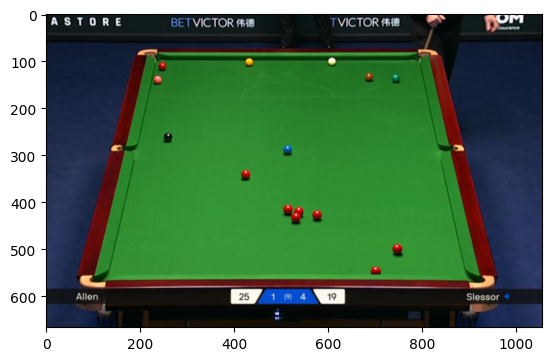

In [2]:
picname = 'pic_06_24_01'  # _06_09_02     pic_01_43_02
pic = read_image_as_numpyimage(f'pics/{picname}.png', 'rgb') # pic_02_07_01.png   pic_05_18_01.png  pic_08_08_01.png pic_06_16_02.png
cropped_pic = crop_center(pic)

display_img(pic)

In [3]:
finder = PlayfieldFinder(pic)
bottom_cushion = finder.find_bottom_internal_cushion()
top_cushion = finder.find_top_internal_cushion()
side_lines = finder.find_internal_side_cushions()
bottom_cushion, top_cushion, *side_lines

(y = 0.0 * x + 555.0,
 y = 0.0 * x + 90.0,
 y = -4.366071428571429 * x + 1124.4910714285716,
 y = 4.701923076923077 * x + -3642.9230769230767)

In [4]:
compute_intersections([bottom_cushion, top_cushion, *side_lines], pic)

[Point (130, 555) line1: [y = -4.37 * x + 1124.49] line2: [y = 0.00 * x + 555.00],
 Point (892, 555) line1: [y = 0.00 * x + 555.00] line2: [y = 4.70 * x + -3642.92],
 Point (236, 90) line1: [y = -4.37 * x + 1124.49] line2: [y = 0.00 * x + 90.00],
 Point (793, 90) line1: [y = 0.00 * x + 90.00] line2: [y = 4.70 * x + -3642.92]]

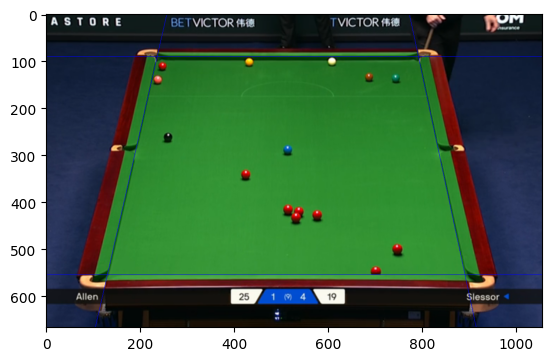

In [5]:
for line in [bottom_cushion, top_cushion, *side_lines]:
    cv2.line(pic, *line.limit_to_img(pic), (0, 0, 255), 1)
display_img(pic)

In [6]:
polygon_annp = PolygonAnnotation(root_dir='playfield_gt')
polygon_annp.read(Path('playfield_gt/all.json'))

In [7]:
not_found = []
iou_results = []
results = []
root = Path('pics')
for file in sorted(root.glob('*.png')):#[18:19]:
    try:
        pic = read_image_as_numpyimage(file, 'rgb')
        pic_copy = pic.copy()

        data = polygon_annp.filter_by_image(file.name)
        points_gt = np.asarray(transform_annotation(pic, data.points))
        gt_left_top, gt_left_bottom, gt_right_top, gt_right_bottom = [(int(point[0]), int(point[1])) for point in get_corners(points_gt)]

        pic_copy = plot_on_image(pic_copy, polygons=[[gt_left_top, gt_left_bottom, gt_right_bottom, gt_right_top]])

        finder = PlayfieldFinder(pic)
        bottom_cushion = finder.find_bottom_internal_cushion()
        top_cushion = finder.find_top_internal_cushion()
        side_lines = finder.find_internal_side_cushions()

        all_lines = [bottom_cushion, top_cushion, *side_lines]
        internal_intersection = compute_intersections(all_lines, pic)
        lt, lb, rt, rb = get_corners(PlayfieldFinder.intersection_to_points_array(internal_intersection))

        pic_copy = plot_on_image(pic_copy, polygons=[[lt, lb, rb, rt]], polygon_color=(255, 0, 0))
        iou_result = iou(points_gt, [lt, lb, rb, rt])

        iou_results.append(iou_result)

        results.append({
            'pic_name': file.stem,
            'iou': iou_result,
        })
        
        iou_text = f"IOU: {iou_result:.3f}"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1.0
        thickness = 2

        pic_bgr = cv2.cvtColor(pic_copy, cv2.COLOR_RGB2BGR)
        text_color_bgr = (0, 255, 0)
        (text_width, text_height), baseline = cv2.getTextSize(iou_text, font, font_scale, thickness)
        

        cv2.rectangle(pic_bgr, (10, 10), (10 + text_width + 10, 10 + text_height + baseline + 10), (0, 0, 0), -1)
        cv2.putText(pic_bgr, iou_text, (15, 10 + text_height), font, font_scale, text_color_bgr, thickness)
        pic_copy = cv2.cvtColor(pic_bgr, cv2.COLOR_BGR2RGB)

        cv2.imwrite(f'tests/side_lines_tests/{file.stem}_left.png', cv2.cvtColor(pic_copy, cv2.COLOR_BGR2RGB))

    except Exception as e:
        print(file.stem, e)
        not_found.append(file.stem)

pic_01_41_02 not enough values to unpack (expected 2, got 1)
pic_01_46_01 not enough values to unpack (expected 2, got 0)


In [9]:
not_found

['pic_01_41_02', 'pic_01_46_01']

In [9]:
pd.DataFrame(results).to_excel('iou_results.xlsx', index=False)

In [18]:
np.median(iou_results), np.mean(iou_results), np.std(iou_results), np.min(iou_results), np.max(iou_results)

(np.float64(0.988985461324253),
 np.float64(0.9886333014404561),
 np.float64(0.0036480881701862014),
 np.float64(0.9764055062573126),
 np.float64(0.9964880978765492))

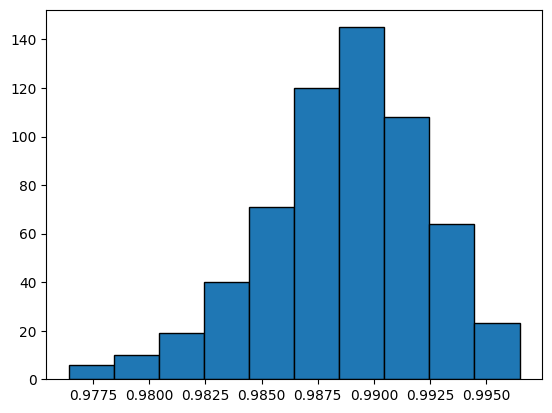

In [20]:
plt.hist(iou_results, edgecolor='black')
plt.show()